In [1]:
import random
import traceback
from heapq import heappop, heappush
from pathlib import Path
from textwrap import dedent
from typing import Callable, Dict, Iterable, List, Optional, Tuple, Type, Union

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
from PIL import Image, ImageDraw
import pandas as pd
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
from model import TransPathModel, GridData
import math

epsilon = 1e-3

%matplotlib inline

In [2]:

class Map:
    """
    Represents a square grid environment for our moving agent.

    Attributes
    ----------
    _width : int
        The number of columns in the grid.

    _height : int
        The number of rows in the grid.

    _cells : np.ndarray
        A binary matrix representing the grid where 0 represents a traversable cell, and 1 represents a blocked cell.
    """

    def __init__(self, cells: npt.NDArray):
        """
        Initializes the map using a 2D array of cells.

        Parameters
        ----------
        cells : np.ndarray
            A binary matrix representing the grid. 0 indicates a traversable cell, and 1 indicates a blocked cell.
        """
        self._width = cells.shape[1]
        self._height = cells.shape[0]
        self._cells = cells

    def in_bounds(self, i: int, j: int) -> bool:
        """
        Checks if the cell (i, j) is within the grid boundaries.

        Parameters
        ----------
        i : int
            Row number of the cell in the grid.
        j : int
            Column number of the cell in the grid.

        Returns
        ----------
        bool
            True if the cell is inside the grid, False otherwise.
        """
        return 0 <= j < self._width and 0 <= i < self._height

    def traversable(self, i: int, j: int) -> bool:
        """
        Checks if the cell (i, j) is not an obstacle.

        Parameters
        ----------
        i : int
            Row number of the cell in the grid.
        j : int
            Column number of the cell in the grid.

        Returns
        ----------
        bool
            True if the cell is traversable, False if it's blocked.
        """
        return not self._cells[i, j]

    def get_neighbors(self, i: int, j: int) -> List[Tuple[int, int]]:
        """
        Gets a list of neighboring cells as (i, j) tuples.
        Assumes that the grid is 4-connected, allowing moves only in cardinal directions.

        Parameters
        ----------
        i : int
            Row number of the cell in the grid.
        j : int
            Column number of the cell in the grid.

        Returns
        ----------
        neighbors : List[Tuple[int, int]]
            List of neighboring cells.
        """
        neighbors = []
        delta = ((0, 1), (1, 0), (0, -1), (-1, 0), (1, 1), (-1, 1), (-1, -1), (1, -1))
        for dx, dy in delta:
            ni, nj = i + dx, j + dy
            if self.in_bounds(ni, nj) and self.traversable(ni, nj):
                neighbors.append((ni, nj))
        return neighbors

    def get_size(self) -> Tuple[int, int]:
        """
        Returns the size of the grid in cells.

        Returns
        ----------
        (height, width) : Tuple[int, int]
            Number of rows and columns in the grid.
        """
        return self._height, self._width

In [3]:

def compute_cost(i1: int, j1: int, i2: int, j2: int) -> Union[int, float]:
    """
    Computes the cost of simple moves between cells (i1, j1) and (i2, j2).

    Parameters
    ----------
    i1 : int
        Row number of the first cell in the grid.
    j1 : int
        Column number of the first cell in the grid.
    i2 : int
        Row number of the second cell in the grid.
    j2 : int
        Column number of the second cell in the grid.

    Returns
    ----------
    int | float
        Cost of the move between cells.

    Raises
    ----------
    ValueError
        If trying to compute the cost of a non-supported move.
    """
    if abs(i1 - i2) + abs(j1 - j2) == 1:  # Cardinal move
        return 1
    elif abs(i1 - i2) == 1 and abs(j1 - j2) == 1:
        return 2 ** 0.5
    else:
        raise ValueError("Trying to compute the cost of a non-supported move!")

In [4]:

class Node:
    """
    Represents a search node.

    Attributes
    ----------
    i : int
        Row coordinate of the corresponding grid element.
    j : int
        Column coordinate of the corresponding grid element.
    g : float | int
        g-value of the node.
    h : float | int
        h-value of the node
    f : float | int
        f-value of the node
    parent : Node
        Pointer to the parent node.
    """

    def __init__(
        self,
        i: int,
        j: int,
        g: Union[float, int] = 0,
        h: Union[float, int] = 0,
        f: Optional[Union[float, int]] = None,
        parent: "Node" = None,
    ):
        """
        Initializes a search node.

        Parameters
        ----------
        i : int
            Row coordinate of the corresponding grid element.
        j : int
            Column coordinate of the corresponding grid element.
        g : float | int
            g-value of the node.
        h : float | int
            h-value of the node (always 0 for Dijkstra).
        f : float | int
            f-value of the node (always equal to g-value for Dijkstra).
        parent : Node
            Pointer to the parent node.
        """
        self.i = i
        self.j = j
        self.g = g
        self.h = h
        if f is None:
            self.f = self.g + h
        else:
            self.f = f
        self.parent = parent

    def __eq__(self, other):
        """
        Checks if two search nodes are the same, which is needed to detect duplicates in the search tree.
        """
        return (self.i == other.i) and (self.j == other.j)

    def __hash__(self):
        """
        Makes the Node object hashable, allowing it to be used in sets/dictionaries.
        """
        return hash((self.i, self.j))

    def __lt__(self, other):
        """
        Compares the keys (i.e., the f-values) of two nodes, needed for sorting/extracting the best element from OPEN.
        """
        if abs(self.f - other.f) < epsilon: # tie-break
            return self.g > other.g
        return self.f < other.f

In [5]:
class FNode:

    def __init__(
        self,
        node: Node,
        h_focal: Union[float, int] = 0,
    ):
        self.node = node
        self.h_focal = h_focal

    def __eq__(self, other):
        return self.node == other.node

    def __hash__(self):
        return hash(self.node)

    def __lt__(self, other):
        if abs(self.h_focal - other.h_focal) < epsilon: # tie-break
            return self.node < other.node
        return self.h_focal > other.h_focal

In [6]:
class SearchTreePQD:
    """
    SearchTree using a priority queue for OPEN and a dictionary for CLOSED.
    """

    def __init__(self):
        self._open = []  # Priority queue for nodes in OPEN
        self._closed = {}  # Dictionary for nodes in CLOSED (expanded nodes)
        self._enc_open_dublicates = 0  # Number of dublicates encountered in OPEN

    def __len__(self) -> int:
        """
        Returns the size of the search tree. Useful for assessing the memory
        footprint of the algorithm, especially at the final iteration.
        """
        return len(self._open) + len(self._closed)

    def open_is_empty(self) -> bool:
        """
        Checks if OPEN is empty.
        If true, the main search loop should be interrupted.
        """
        return len(self._open) == 0

    def add_to_open(self, item: Node):
        """
        Adds a node to the search tree, specifically to OPEN. This node is either
        entirely new or a duplicate of an existing node in OPEN.
        This implementation detects duplicates lazily; thus, nodes are added to
        OPEN without initial duplicate checks.
        """
        heappush(self._open, item)

    def get_best_node_from_open(self) -> Optional[Node]:
        """
        Retrieves the best node from OPEN, defined by the minimum key.
        This node will then be expanded in the main search loop.

        Duplicates are managed here. If a node has been expanded previously
        (and is in CLOSED), it's skipped and the next best node is considered.

        Returns None if OPEN is empty.
        """
        if not self._open or len(self._open) == 0:
            return None
        best_node = heappop(self._open)
        while self.was_expanded(best_node):
            self._enc_open_dublicates += 1
            if not self._open or len(self._open) == 0:
                return None 
            best_node = heappop(self._open)
        return best_node

    def add_to_closed(self, item: Node):
        """
        Adds a node to the CLOSED dictionary.
        """
        self._closed[item] = item

    def was_expanded(self, item: Node) -> bool:
        """
        Checks if a node has been previously expanded.
        """
        return item in self._closed

    @property
    def opened(self):
        return self._open

    @property
    def expanded(self):
        return self._closed

    @property
    def number_of_open_dublicates(self):
        return self._enc_open_dublicates

In [7]:

def make_path(goal: Node) -> Tuple[List[Node], Union[float, int]]:
    """
    Creates a path by tracing parent pointers from the goal node to the start node.
    It also returns the path's length.

    Parameters
    ----------
    goal : Node
        Pointer to the goal node in the search tree.

    Returns
    -------
    Tuple[List[Node], float]
        Path and its length.
    """
    length = goal.g
    current = goal
    path = []
    while current.parent:
        path.append(current)
        current = current.parent
    path.append(current)
    return path[::-1], length

In [8]:
def octile_distance(i1: int, j1: int, i2: int, j2: int) -> int:
    """
    Computes the Manhattan distance between two cells on a grid.

    Parameters
    ----------
    i1, j1 : int
        (i, j) coordinates of the first cell on the grid.
    i2, j2 : int
        (i, j) coordinates of the second cell on the grid.

    Returns
    -------
    int
        Manhattan distance between the two cells.
    """
    return abs(abs(i1 - i2) - abs(j1 - j2)) + min(abs(i1 - i2), abs(j1 - j2)) * 2 ** 0.5

def euclidean_distance(i1: int, j1: int, i2: int, j2: int) -> int:
    """
    Computes the Manhattan distance between two cells on a grid.

    Parameters
    ----------
    i1, j1 : int
        (i, j) coordinates of the first cell on the grid.
    i2, j2 : int
        (i, j) coordinates of the second cell on the grid.

    Returns
    -------
    int
        Manhattan distance between the two cells.
    """
    return ((i1 - i2) ** 2 + (j1 - j2) ** 2) ** 0.5

In [9]:

def astar(
    task_map: Map,
    start_i: int,
    start_j: int,
    goal_i: int,
    goal_j: int,
    heuristic: np.ndarray,
    search_tree: Type[SearchTreePQD],
) -> Tuple[bool, Optional[Node], int, int, Optional[Iterable[Node]], Optional[Iterable[Node]]]:
    """
    Implements the A* search algorithm.

    Parameters
    ----------
    task_map : Map
        The grid or map being searched.
    start_i, start_j : int, int
        Starting coordinates.
    goal_i, goal_j : int, int
        Goal coordinates.
    heuristic : np.ndarray
        Heuristic for estimating the distance from a node to the goal.
    search_tree : Type[SearchTreePQD]
        The search tree to use.

    Returns
    -------
    Tuple[bool, Optional[Node], int, int, Optional[Iterable[Node]], Optional[Iterable[Node]]]
        Tuple containing:
        - A boolean indicating if a path was found.
        - The last node in the found path or None.
        - Number of algorithm iterations.
        - Size of the resultant search tree.
        - OPEN set nodes for visualization or None.
        - CLOSED set nodes.
    """
    ast = search_tree()
    steps = 0

    start_node = Node(start_i, start_j, g=0, h=heuristic[start_i, start_j])
    ast.add_to_open(start_node)

    goal_node = Node(goal_i, goal_j)

    while not ast.open_is_empty():
        steps += 1
        best = ast.get_best_node_from_open()
        if not best:
            break
        if goal_node == best:
            return True, best, steps, len(ast), ast.opened, ast.expanded
        neighbours = task_map.get_neighbors(best.i, best.j)
        for neighbour in neighbours:
            cur_node = Node(neighbour[0], neighbour[1], g=(best.g + compute_cost(best.i, best.j, neighbour[0], neighbour[1])), h=heuristic[neighbour[0], neighbour[1]], parent=best)
            if not ast.was_expanded(cur_node):
                ast.add_to_open(cur_node)
        ast.add_to_closed(best)

    return False, None, steps, len(ast), None, ast.expanded

In [10]:
def draw_rectangle(draw, node, scale, color):
    """Draws a rectangle on the grid, given the node and the desired color."""
    draw.rectangle(
        (
            node.j * scale,
            node.i * scale,
            (node.j + 1) * scale - 1,
            (node.i + 1) * scale - 1,
        ),
        fill=color,
        width=0,
    )


def draw(
    grid_map: Map,
    start: Optional[Node] = None,
    goal: Optional[Node] = None,
    path: Optional[Iterable[Node]] = None,
    nodes_discovered: Optional[Iterable[Node]] = None,
    nodes_expanded: Optional[Iterable[Node]] = None,
    nodes_reexpanded: Optional[Iterable[Node]] = None,
):
    """
    Visualizes the environment, path, and expanded/not yet expanded/re-expanded nodes.

    Parameters
    ----------
    grid_map : Map
        Environment represented as a grid.
    start, goal : Optional[Node], Optional[Node]
        Nodes for the start and goal positions of the agent.
    path : Optional[Iterable[Node]]
        Sequence of nodes representing the path between start and goal.
    nodes_discovered : Optional[Iterable[Node]]
        Nodes that were discovered during the search process.
    nodes_expanded : Optional[Iterable[Node]]
        Nodes that were expanded during the search process.
    nodes_reexpanded : Optional[Iterable[Node]]
        Nodes that were re-expanded during the search process.
    """
    scale = 5
    height, width = grid_map.get_size()
    im = Image.new("RGB", (width * scale, height * scale), color="white")
    draw = ImageDraw.Draw(im)

    # Draw blocked cells
    for i in range(height):
        for j in range(width):
            if not grid_map.traversable(i, j):
                draw.rectangle(
                    (j * scale, i * scale, (j + 1) * scale - 1, (i + 1) * scale - 1),
                    fill=(70, 80, 80),
                )

    node_colors = [
        (nodes_discovered, (213, 219, 219)),
        (nodes_expanded, (131, 145, 146)),
        (nodes_reexpanded, (255, 145, 146)),
    ]

    for nodes, color in node_colors:
        if nodes is not None:
            for node in nodes:
                draw_rectangle(draw, node, scale, color)

    if path is not None:
        for step in path:
            color = (52, 152, 219) if grid_map.traversable(step.i, step.j) else (230, 126, 34)
            draw_rectangle(draw, step, scale, color)

    if start is not None and grid_map.traversable(start.i, start.j):
        draw_rectangle(draw, start, scale, (40, 180, 99))

    if goal is not None and grid_map.traversable(goal.i, goal.j):
        draw_rectangle(draw, goal, scale, (231, 76, 60))

    _, ax = plt.subplots(dpi=150)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(np.asarray(im))
    plt.show()

In [11]:
def astar_func(
    task_map: Map,
    start_i: int,
    start_j: int,
    goal_i: int,
    goal_j: int,
    heuristic_func: Callable,
    search_tree: Type[SearchTreePQD],
) -> Tuple[bool, Optional[Node], int, int, Optional[Iterable[Node]], Optional[Iterable[Node]]]:
    """
    Implements the A* search algorithm.

    Parameters
    ----------
    task_map : Map
        The grid or map being searched.
    start_i, start_j : int, int
        Starting coordinates.
    goal_i, goal_j : int, int
        Goal coordinates.
    heuristic_func : Callable
        Heuristic function for estimating the distance from a node to the goal.
    search_tree : Type[SearchTreePQD]
        The search tree to use.

    Returns
    -------
    Tuple[bool, Optional[Node], int, int, Optional[Iterable[Node]], Optional[Iterable[Node]]]
        Tuple containing:
        - A boolean indicating if a path was found.
        - The last node in the found path or None.
        - Number of algorithm iterations.
        - Size of the resultant search tree.
        - OPEN set nodes for visualization or None.
        - CLOSED set nodes.
    """
    ast = search_tree()
    steps = 0

    start_node = Node(start_i, start_j, g=0, h=heuristic_func(start_i, start_j, goal_i, goal_j))
    ast.add_to_open(start_node)

    goal_node = Node(goal_i, goal_j)

    while not ast.open_is_empty():
        steps += 1
        best = ast.get_best_node_from_open()
        if not best:
            break
        if goal_node == best:
            return True, best, steps, len(ast), ast.opened, ast.expanded
        neighbours = task_map.get_neighbors(best.i, best.j)
        for neighbour in neighbours:
            cur_node = Node(neighbour[0], neighbour[1], g=(best.g + compute_cost(best.i, best.j, neighbour[0], neighbour[1])), h=heuristic_func(neighbour[0], neighbour[1], goal_i, goal_j), parent=best)
            if not ast.was_expanded(cur_node):
                ast.add_to_open(cur_node)
        ast.add_to_closed(best)

    return False, None, steps, len(ast), None, ast.expanded

In [12]:
def line_of_sight(task_map: Map, start: Node, end: Node) -> bool:
    """
    Checks if there is a direct line of sight between two nodes.
    Uses Bresenham's line algorithm to validate traversability.
    """
    x0, y0, x1, y1 = start.i, start.j, end.i, end.j
    dx, dy = abs(x1 - x0), abs(y1 - y0)
    sx, sy = (1 if x0 < x1 else -1), (1 if y0 < y1 else -1)
    err = dx - dy

    while x0 != x1 or y0 != y1:
        if not task_map.traversable(x0, y0):
            return False
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy

    return task_map.traversable(x1, y1)

def thetastar( 
    task_map: Map,
    start_i: int,
    start_j: int,
    goal_i: int,
    goal_j: int,
    heuristic_func: Callable,
    search_tree: Type[SearchTreePQD],
) -> Tuple[bool, Optional[Node], int, int, Optional[Iterable[Node]], Optional[Iterable[Node]]]:
    """
    Implements the theta* search algorithm.

    Parameters
    ----------
    task_map : Map
        The grid or map being searched.
    start_i, start_j : int, int
        Starting coordinates.
    goal_i, goal_j : int, int
        Goal coordinates.
    heuristic_func : Callable
        Heuristic function for estimating the distance from a node to the goal.
    search_tree : Type[SearchTreePQD]
        The search tree to use.

    Returns
    -------
    Tuple[bool, Optional[Node], int, int, Optional[Iterable[Node]], Optional[Iterable[Node]]]
        Tuple containing:
        - A boolean indicating if a path was found.
        - The last node in the found path or None.
        - Number of algorithm iterations.
        - Size of the resultant search tree.
        - OPEN set nodes for visualization or None.
        - CLOSED set nodes.
    """
    # Initialize search tree
    search_tree_instance = search_tree()

    # Create start and goal nodes
    start_node = Node(start_i, start_j, g=0, h=heuristic_func(start_i, start_j, goal_i, goal_j))
    goal_node = Node(goal_i, goal_j)

    # Add the start node to OPEN
    search_tree_instance.add_to_open(start_node)

    iterations = 0

    found = False

    while not search_tree_instance.open_is_empty():
        # Get the best node from OPEN
        current_node = search_tree_instance.get_best_node_from_open()

        if current_node is None:
            break

        # If the goal is reached, reconstruct the path
        if current_node == goal_node and not found:
            found = True
            goal_node = current_node
            break

        # Process neighbors
        for ni, nj in task_map.get_neighbors(current_node.i, current_node.j):
            neighbor = Node(ni, nj)
            neighbor.g = float("inf")  # Temporary value

            if current_node.parent and line_of_sight(task_map, current_node.parent, neighbor):
                # Shortcut using line of sight from current_node's parent
                tentative_g = current_node.parent.g + math.hypot(ni - current_node.parent.i, nj - current_node.parent.j)
                if tentative_g < neighbor.g:
                    neighbor.g = tentative_g
                    neighbor.h = heuristic_func(ni, nj, goal_i, goal_j)
                    neighbor.f = neighbor.g + neighbor.h
                    neighbor.parent = current_node.parent
            else:
                # Standard update using current_node
                tentative_g = current_node.g + math.hypot(ni - current_node.i, nj - current_node.j)
                if tentative_g < neighbor.g:
                    neighbor.g = tentative_g
                    neighbor.h = heuristic_func(ni, nj, goal_i, goal_j)
                    neighbor.f = neighbor.g + neighbor.h
                    neighbor.parent = current_node

            if not search_tree_instance.was_expanded(neighbor):
                search_tree_instance.add_to_open(neighbor)

        # Move current_node to CLOSED
        search_tree_instance.add_to_closed(current_node)
        iterations += 1

    if found:
        return (
                True,
                goal_node,
                iterations,
                len(search_tree_instance),
                search_tree_instance.opened,
                search_tree_instance.expanded,
            )

    # No path found
    return (
        False,
        None,
        iterations,
        len(search_tree_instance),
        search_tree_instance.opened,
        search_tree_instance.expanded,
    )


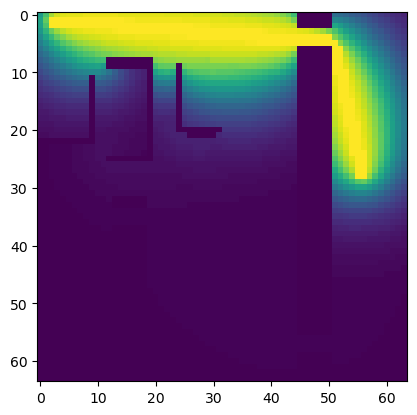

1243 72.14162022289923 [(np.int64(1), np.int64(2)), (np.int64(5), np.int64(50)), (np.int64(6), np.int64(51)), (np.int64(28), np.int64(56))]


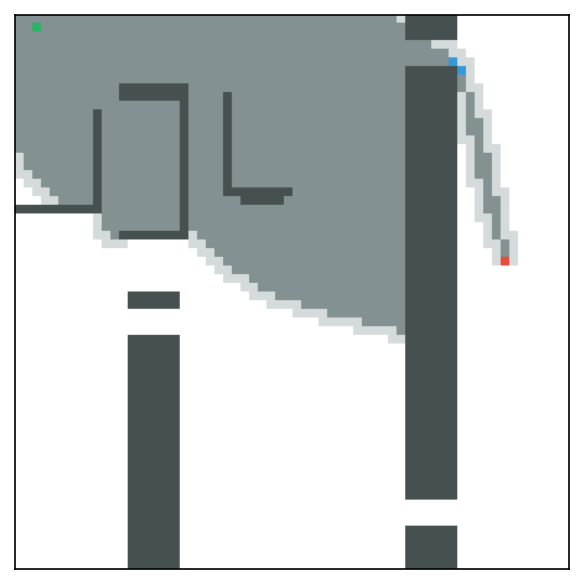

In [14]:
dataset_path = './TransPath_data/test'

cells = np.load(f'{dataset_path}/maps.npy', mmap_mode='c')
starts = np.load(f'{dataset_path}/starts.npy', mmap_mode='c')
goals = np.load(f'{dataset_path}/goals.npy', mmap_mode='c')
true_heuristics = np.load(f'{dataset_path}/focal.npy', mmap_mode='c')
i = 0
map_0 = Map(cells[i, 0])
start_i, start_j = np.where(starts[i, 0])
start_i, start_j = start_i[0], start_j[0]
goal_i, goal_j = np.where(goals[i, 0])
goal_i, goal_j = goal_i[0], goal_j[0]
plt.imshow(true_heuristics[i, 0])
plt.show()
data = thetastar(map_0, start_i, start_j, goal_i, goal_j, euclidean_distance, SearchTreePQD)
path, length = make_path(data[1])
print(len(data[-1]), length, list(map(lambda x: (x.i, x.j), path)))
draw(map_0, Node(start_i, start_j), Node(goal_i, goal_j), path, data[-2], data[-1])

In [17]:
def ppm(task_map: Map, start_i: int, start_j: int, goal_i: int, goal_j: int) -> np.ndarray:
    """
    Generates a Path Probability Map (PPM) using the Theta* algorithm.

    Parameters
    ----------
    task_map : Map
        The grid or map being searched.
    start_i, start_j : int, int
        Starting coordinates.
    goal_i, goal_j : int, int
        Goal coordinates.

    Returns
    -------
    np.ndarray
        A matrix representing the PPM where:
        - Cells on the shortest Theta* path have a value of 1.
        - Cells close to the Theta* path have pp-values between 0 and 1.
        - All other cells have a pp-value of 0.
    """
    # Initialize the output PPM with zeros
    ppm_matrix = np.zeros((task_map._height, task_map._width), dtype=np.float64)

    # Define the heuristic function (e.g., Euclidean distance)
    def heuristic(i, j, goal_i, goal_j):
        return np.sqrt((i - goal_i) ** 2 + (j - goal_j) ** 2)

    # Create an instance of the search tree
    search_tree = SearchTreePQD()

    # Run Theta* to find the shortest path
    found_path, last_node, _, _, _, start_nodes = thetastar(
        task_map, start_i, start_j, goal_i, goal_j, heuristic, SearchTreePQD
    )

    _, _, _, _, _, goal_nodes = thetastar(
        task_map, goal_i, goal_j, start_i, start_j, heuristic, SearchTreePQD
    )

    if not found_path or last_node is None:
        # No path found; return the empty PPM
        return ppm_matrix

    # Retrieve the path from the goal to the start
    theta_star_path = []
    current = last_node
    while current is not None:
        theta_star_path.append((current.i, current.j))
        current = current.parent

    # Assign pp-values to the path cells (Theta* path cells get value 1)
    for i, j in theta_star_path:
        ppm_matrix[i, j] = 1.0

    # Calculate pp-values for all other cells
    for node in start_nodes:
        if ppm_matrix[node.i, node.j] == 1.0:
            continue  # Skip cells already on the Theta* path

        if task_map.traversable(node.i, node.j):
            cost_start_to_n = node.g
            cost_n_to_goal = goal_nodes[node].g
            cost_through_n = cost_start_to_n + cost_n_to_goal
            theta_cost = last_node.g  # Approximation of Theta* path cost

            # Calculate pp-value
            pp_value = theta_cost / cost_through_n if cost_through_n > 0 else 0
            
            ppm_matrix[node.i, node.j] = pp_value

    return ppm_matrix


In [18]:
heuristic = ppm(map, start_i, start_j, goal_i, goal_j)

KeyError: <__main__.Node object at 0x7fcf8c17d4f0>

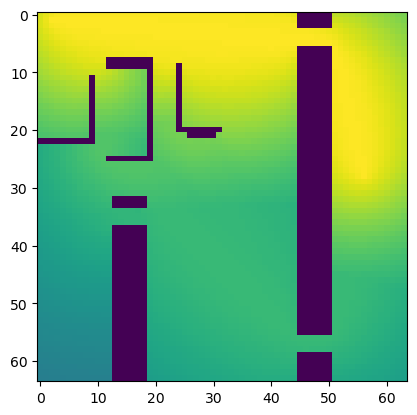

[[0.55 0.71 0.86 ... 0.13 0.12 0.1 ]
 [0.58 0.76 1.   ... 0.15 0.13 0.12]
 [0.57 0.72 1.   ... 0.18 0.15 0.13]
 ...
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]]
[[0.94351257 0.96647714 0.98507085 ... 0.82085145 0.81015574 0.79939696]
 [0.94754886 0.97306901 1.         ... 0.8322652  0.82104316 0.80978617]
 [0.94548438 0.96858824 0.98730951 ... 0.84132574 0.83035282 0.8190093 ]
 ...
 [0.43796577 0.43956608 0.44121591 ... 0.5865531  0.58125358 0.57589556]
 [0.43307477 0.43456888 0.43613211 ... 0.58035288 0.57526498 0.57011119]
 [0.42805922 0.4296658  0.43114848 ... 0.57404518 0.56917308 0.56422737]]


In [16]:
plt.imshow(heuristic)
plt.show()
print(true_heuristics[i, 0])
print(heuristic)